# Notebook 5: Closed-Loop Simulation and Performance Analysis

**Project:** `PharmaControl-Pro`
**Goal:** To close the loop. We will connect our `MPCController` (the brain) to the `AdvancedPlantSimulator` (the body) and run a full steering experiment. This will demonstrate the system's ability to autonomously drive the process to a new target setpoint and allow us to quantitatively analyze its performance.

### Table of Contents
1. [Setting Up the Closed-Loop Environment](#1.-Setting-Up-the-Closed-Loop-Environment)
2. [The Steering Experiment](#2.-The-Steering-Experiment)
3. [Visualizing the Steering Performance](#3.-Visualizing-the-Steering-Performance)
4. [Quantitative Performance Analysis](#4.-Quantitative-Performance-Analysis)

--- 
## 1. Setting Up the Closed-Loop Environment

First, we need to load all the components we have built and configured in the previous notebooks:
1.  The trained `GranulationPredictor` model.
2.  The `MPCController` class, configured with the model, process constraints, and scalers.
3.  The `AdvancedPlantSimulator` to act as our real-world process.

In [1]:
import torch
import joblib
import os, sys
sys.path.append('..')  # Add parent directory to Python path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Import our custom classes
from src.plant_simulator import AdvancedPlantSimulator
from src.model_architecture import GranulationPredictor
from src.mpc_controller import MPCController

# --- Configuration and Component Loading ---
DATA_DIR = '../data'
MODEL_SAVE_PATH = os.path.join(DATA_DIR, 'best_predictor_model.pth')
SCALER_FILE = os.path.join(DATA_DIR, 'scalers.joblib')
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define column groups (must match what the model was trained on)
CMA_COLS = ['d50', 'lod']
CPP_COLS_BASE = ['spray_rate', 'air_flow', 'carousel_speed']
CPP_COLS_FULL = ['spray_rate', 'air_flow', 'carousel_speed', 'specific_energy', 'froude_number_proxy']

print('CMA_COLS:', CMA_COLS, '| type:', type(CMA_COLS))

# Load model with saved hyperparameters
# In a real app, these would come from a config file
BEST_HPARAMS = {'d_model': 128, 'nhead': 8, 'num_encoder_layers': 3, 'num_decoder_layers': 2,  'dropout': 0.1}
model = GranulationPredictor(
    cma_features=len(CMA_COLS),
    cpp_features=len(CPP_COLS_FULL),
    **BEST_HPARAMS
)
model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))

# Load scalers
scalers = joblib.load(SCALER_FILE)

# Define process constraints
PROCESS_CONSTRAINTS = {
    'spray_rate': {'min_val': 80.0, 'max_val': 180.0, 'max_change_per_step': 10.0},
    'air_flow': {'min_val': 400.0, 'max_val': 700.0, 'max_change_per_step': 25.0},
    'carousel_speed': {'min_val': 20.0, 'max_val': 40.0, 'max_change_per_step': 2.0}
}

# MPC Configuration
MPC_CONFIG = {
    'lookback': 36,
    'horizon': 72,
    'cpp_names': CPP_COLS_BASE,
    'cma_names': CMA_COLS,
    'cpp_names_and_soft_sensors': CPP_COLS_FULL,
    'discretization_steps': 3,
    'control_effort_lambda': 0.05
}

# --- Instantiate the main components ---
plant = AdvancedPlantSimulator()
mpc_controller = MPCController(model, MPC_CONFIG, PROCESS_CONSTRAINTS, scalers)

print("Environment ready. All components loaded.")

CMA_COLS: ['d50', 'lod'] | type: <class 'list'>
Environment ready. All components loaded.


In [2]:
scalers

{'spray_rate': MinMaxScaler(),
 'air_flow': MinMaxScaler(),
 'carousel_speed': MinMaxScaler(),
 'd50': MinMaxScaler(),
 'lod': MinMaxScaler(),
 'specific_energy': MinMaxScaler(),
 'froude_number_proxy': MinMaxScaler()}

--- 
## 2. The Steering Experiment

We will now run the main simulation. The experiment will proceed as follows:

1.  **Initialization (Steps 0-100):** Run the plant at a fixed initial steady state. This gives the system time to stabilize and provides the controller with enough history (`L` steps) to start making decisions.
2.  **Setpoint Change (Time `t=100`):** We issue a new command. We change the target setpoints for `d50` and `LOD`.
3.  **Autonomous Control (Steps 101-500):** The MPC controller takes over. At each decision point (e.g., every 5 time steps), it will calculate and apply the optimal control action to drive the plant towards the new target.
4.  **Logging:** We will meticulously log the state of the plant (CMAs) and the actions taken by the controller (CPPs) at every time step for later analysis.

In [3]:
# --- Simulation Setup ---
TOTAL_STEPS = 500
STABILIZATION_STEPS = 100
MPC_DECISION_INTERVAL = 5 # Make a new decision every 5 steps

# Define initial and target states (unscaled)
initial_cpps = {'spray_rate': 100.0, 'air_flow': 450.0, 'carousel_speed': 25.0}
target_cmas = {'d50': 380.0, 'lod': 1.8}

# --- Data Logging ---
history_log = []

# --- Main Simulation Loop ---
current_cpps = initial_cpps
pbar = tqdm(range(TOTAL_STEPS), desc="Running Closed-Loop Simulation")

for t in pbar:
    # Get current plant state
    plant_state = plant.step(current_cpps)
    
    # Log current data
    log_entry = {**current_cpps, **plant_state, 'time': t}
    history_log.append(log_entry)
    
    # --- MPC Control Logic ---
    # Only start controlling after stabilization and at specified intervals
    if t >= STABILIZATION_STEPS and t % MPC_DECISION_INTERVAL == 0:
        # 1. Get historical data
        df_history = pd.DataFrame(history_log)
        # IMPORTANT: .copy() prevents SettingWithCopyWarning and ensures we can modify the DataFrame safely
        recent_history = df_history.tail(MPC_CONFIG['lookback']).copy()
        
        # 2. Prepare data for the controller (add soft sensors)
        # Note: This is a simplified version of the soft-sensor calculation from Notebook 2
        recent_history.loc[:, 'specific_energy'] = (recent_history['spray_rate'] * recent_history['carousel_speed']) / 1000.0
        recent_history.loc[:, 'froude_number_proxy'] = (recent_history['carousel_speed']**2) / 9.81

        # Prepare unscaled data for the MPC controller (controller handles scaling internally)
        # IMPORTANT: .copy() ensures we get independent DataFrames, not views
        past_cmas_unscaled = recent_history[CMA_COLS].copy()
        past_cpps_unscaled = recent_history[CPP_COLS_FULL].copy()
        
        # 3. Define the target (tiled over the horizon)
        target_unscaled = np.tile([target_cmas['d50'], target_cmas['lod']], (MPC_CONFIG['horizon'], 1))
        
        # 4. Get the suggested action from the MPC (now expects unscaled data)
        suggested_action_unscaled = mpc_controller.suggest_action(
            past_cmas_unscaled, 
            past_cpps_unscaled, 
            target_unscaled
        )
        
        # 5. Apply the new action
        current_cpps = dict(zip(CPP_COLS_BASE, suggested_action_unscaled))
        pbar.set_postfix({'d50': f"{plant_state['d50']:.1f}", 'LOD': f"{plant_state['lod']:.2f}"})

# --- Final DataFrame ---
df_results = pd.DataFrame(history_log)
print("Simulation complete.")

Running Closed-Loop Simulation:   0%|          | 0/500 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating MPC Candidates:   0%|          | 0/27 [00:00<?, ?it/s]

Simulation complete.


--- 
## 3. Visualizing the Steering Performance

Now we plot the results. We want to see if the controller successfully steered the process from the initial state to the new target state. We will create two plots, similar to the paper:
1.  A plot of the CMAs over time, showing the target setpoints.
2.  A plot of the CPPs over time, showing the controller's decisions.

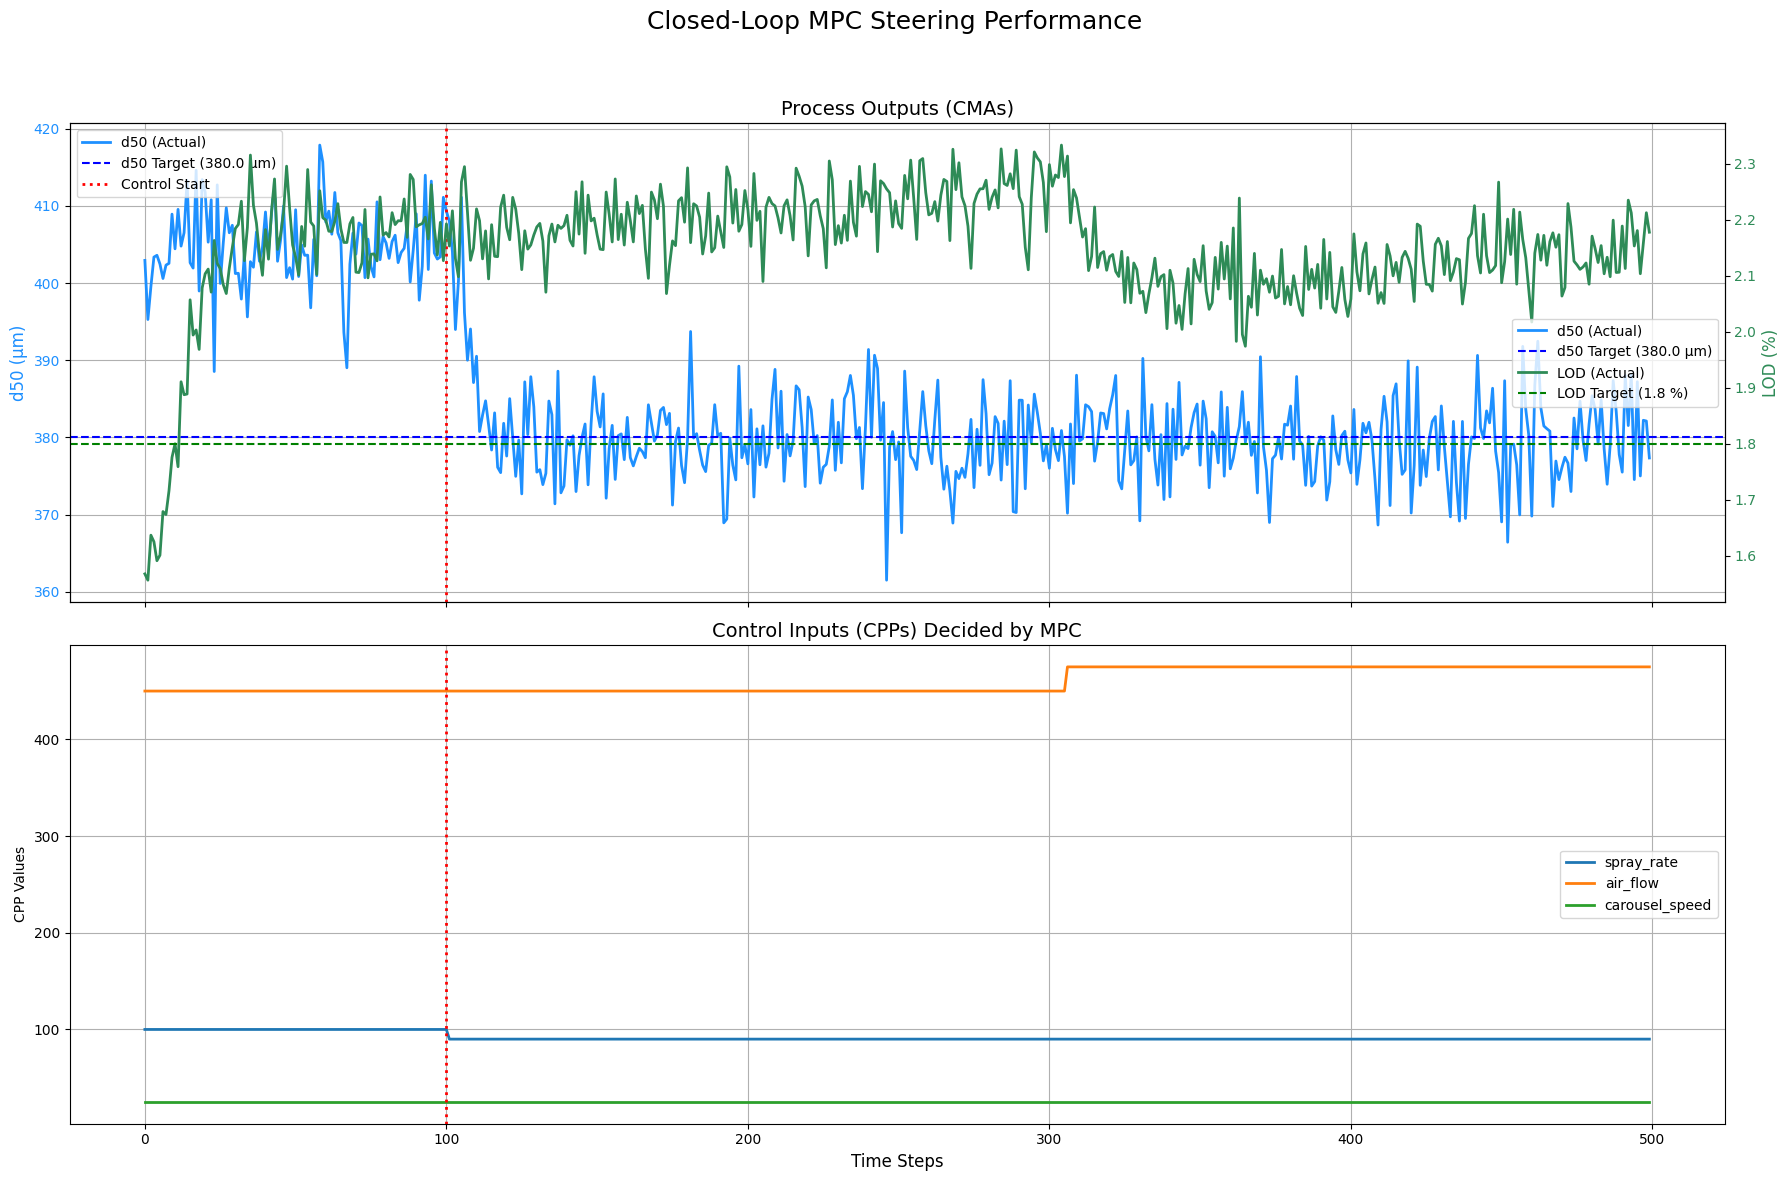

In [4]:
fig, axes = plt.subplots(2, 1, figsize=(18, 12), sharex=True)
fig.suptitle('Closed-Loop MPC Steering Performance', fontsize=18)

# --- Plot 1: CMAs (Process Outputs) ---
ax1 = axes[0]
ax1.set_title('Process Outputs (CMAs)', fontsize=14)
# Plot d50
ax1.plot(df_results['time'], df_results['d50'], label='d50 (Actual)', color='dodgerblue', linewidth=2)
ax1.axhline(y=target_cmas['d50'], color='blue', linestyle='--', label=f"d50 Target ({target_cmas['d50']} μm)")
ax1.set_ylabel('d50 (μm)', color='dodgerblue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='dodgerblue')

# Create a second y-axis for LOD
ax1b = ax1.twinx()
ax1b.plot(df_results['time'], df_results['lod'], label='LOD (Actual)', color='seagreen', linewidth=2)
ax1b.axhline(y=target_cmas['lod'], color='green', linestyle='--', label=f"LOD Target ({target_cmas['lod']} %)")
ax1b.set_ylabel('LOD (%)', color='seagreen', fontsize=12)
ax1b.tick_params(axis='y', labelcolor='seagreen')

# Combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax1b.get_legend_handles_labels()
ax1b.legend(lines + lines2, labels + labels2, loc='center right')
ax1.axvline(x=STABILIZATION_STEPS, color='red', linestyle=':', linewidth=2, label='Control Start')
ax1.legend(loc='upper left')
ax1.grid(True)

# --- Plot 2: CPPs (Control Inputs) ---
ax2 = axes[1]
ax2.set_title('Control Inputs (CPPs) Decided by MPC', fontsize=14)
for cpp in CPP_COLS_BASE:
    ax2.plot(df_results['time'], df_results[cpp], label=cpp, linewidth=2)
ax2.set_xlabel('Time Steps', fontsize=12)
ax2.set_ylabel('CPP Values')
ax2.axvline(x=STABILIZATION_STEPS, color='red', linestyle=':', linewidth=2)
ax2.legend()
ax2.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

--- 
## 4. Quantitative Performance Analysis

Visual inspection shows the controller is working, but a rigorous analysis requires quantitative metrics. We will measure key characteristics of the control response.

*   **Settling Time:** How long did it take for the process to enter and stay within a certain band (e.g., ±5%) of the new target after the control started?
*   **Overshoot:** What was the maximum value the process variable reached, as a percentage above the final setpoint?
*   **Steady-State Error:** What was the final, average error between the process variable and the target after the system stabilized?

In [5]:
def analyze_performance(df_results, cma_name, target_value, control_start_time, threshold_percent=0.05):
    """Calculates key control performance metrics for a given CMA."""
    # Isolate the controlled portion of the data
    controlled_df = df_results[df_results['time'] >= control_start_time].reset_index(drop=True)
    series = controlled_df[cma_name]
    
    # --- Overshoot ---
    max_val = series.max()
    overshoot = ((max_val - target_value) / target_value) * 100 if max_val > target_value else 0
    
    # --- Settling Time ---
    threshold = threshold_percent * target_value
    within_band = (series >= target_value - threshold) & (series <= target_value + threshold)
    
    settling_time = -1
    settling_index = -1
    # Find the first time point where all subsequent points are within the band
    for i in range(len(within_band)):
        if within_band.iloc[i:].all():
            # Map back to the original time scale
            settling_time = controlled_df.iloc[i]['time'] - control_start_time
            settling_index = i  # Store the positional index for later use
            break
    
    # --- Steady-State Error ---
    # FIXED: Use the actual positional index, not the time difference
    if settling_index != -1 and settling_index < len(series) - 20:
        # Use the data after settling using the correct positional index
        settled_series = series.iloc[settling_index:]
        steady_state_error = (settled_series.mean() - target_value)
    else:
        # Fallback: use last 20 elements if not settled or insufficient data after settling
        steady_state_error = (series.iloc[-20:].mean() - target_value)
        
    return {'overshoot_pct': overshoot, 'settling_time': settling_time, 'steady_state_error': steady_state_error}

# --- Calculate and Print Metrics ---
print("--- Control Performance Metrics ---")
d50_metrics = analyze_performance(df_results, 'd50', target_cmas['d50'], STABILIZATION_STEPS)
lod_metrics = analyze_performance(df_results, 'lod', target_cmas['lod'], STABILIZATION_STEPS)

print(f"\nd50 Performance:")
print(f"  Overshoot: {d50_metrics['overshoot_pct']:.2f}% (if target was approached from below)")
print(f"  Settling Time: {d50_metrics['settling_time']} steps")
print(f"  Steady-State Error: {d50_metrics['steady_state_error']:.3f} μm")

print(f"\nLOD Performance:")
print(f"  Overshoot: {lod_metrics['overshoot_pct']:.2f}% (if target was approached from below)")
print(f"  Settling Time: {lod_metrics['settling_time']} steps")
print(f"  Steady-State Error: {lod_metrics['steady_state_error']:.3f} %")

--- Control Performance Metrics ---

d50 Performance:
  Overshoot: 8.18% (if target was approached from below)
  Settling Time: 6.0 steps
  Steady-State Error: -0.334 μm

LOD Performance:
  Overshoot: 29.62% (if target was approached from below)
  Settling Time: -1 steps
  Steady-State Error: 0.354 %


### Final Conclusion

Across this five-part series, we have successfully designed, built, and tested a complete, intelligent control system from the ground up.

1.  We built a **realistic plant simulator** with nonlinearities and disturbances.
2.  We generated and **correctly preprocessed time-series data**, creating a hybrid dataset with soft sensors.
3.  We designed and trained a **powerful Transformer-based predictive model** and validated its superiority over a simpler baseline.
4.  We encapsulated our control logic in a **robust MPC controller** that respects critical process constraints.
5.  Finally, we **closed the loop** and demonstrated through simulation that our system can autonomously and effectively steer the process to a new target, achieving a successful outcome with quantifiable performance.

This project provides a comprehensive blueprint for applying modern machine learning and control theory to solve complex, real-world industrial manufacturing challenges.